In [1]:
import os
import numpy as np
import seaborn as sns
from pymbar import BAR
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from glob import glob
import pickle
from simtk.openmm import unit
import bz2
from beryllium import plotting, stats
import pandas as pd
import json
import tqdm
from openmmtools.constants import kB
import networkx as nx

temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [57]:
def form_edge_matrix(g, label, step=None, action=None):
    """
    Extract the labeled property from edges into a matrix

    Parameters
    ----------
    g : nx.Graph
        The graph to extract data from
    label : str
        The label to use for extracting edge properties
    action : str, optional, default=None
        If 'symmetrize', will return a symmetric matrix where A[i,j] = A[j,i]
        If 'antisymmetrize', will return an antisymmetric matrix where A[i,j] = -A[j,i]

    """
    N = len(g.nodes)
    matrix = np.zeros([N,N])
    node_index_map = {j:i for i, j in enumerate(g.nodes)}

    for i, j in g.edges:
        m, n = node_index_map[i],node_index_map[j]        
        matrix[m,n] = g.edges[i,j][label]
        if action == 'symmetrize':
            matrix[n,m] = matrix[m,n]
        elif action == 'antisymmetrize':
            matrix[n,m] = - matrix[m,n]
        elif action is None:
            pass
        else:
            raise Exception(f'action "{action}" unknown.')
    return matrix


def mle(g,factor='f_ij'):
    """
    Compute maximum likelihood estimate of free energies and covariance in their estimates.
    The number 'factor' is the node attribute on which the MLE will be calculated,
    where d'factor' will be used as the standard error of the factor

    We assume the free energy of node 0 is zero.

    Reference : https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00528
    Xu, Huafeng. "Optimal measurement network of pairwise differences." Journal of Chemical Information and Modeling 59.11 (2019): 4720-4728.

    Parameters
    ----------
    g : nx.Graph
        The graph for which an estimate is to be computed
        Each edge must have attributes 'f_ij' and 'df_ij' for the free energy and uncertainty estimate
        Will have 'bayesian_f_ij' and 'bayesian_df_ij' added to each edge
        and 'bayesian_f_i' and 'bayesian_df_i' added to each node.
    factor : string, default = 'f_ij'
        node attribute of nx.Graph that will be used for MLE
    Returns
    -------
    f_i : np.array with shape (n_ligands,)
        f_i[i] is the absolute free energy of ligand i in kT
        f_i[0] = 0

    C : np.array with shape (n_ligands, n_ligands)
        C[i,j] is the covariance of the free energy estimates of i and j

    """
    N = len(g.nodes)
    
    # number of nodes may not be the same as the indices of the nodes
    node_index_map = {j:i for i, j in enumerate(g.nodes)}
    
    f_ij = form_edge_matrix(g, factor, action='antisymmetrize')
    df_ij = form_edge_matrix(g, factor.replace('_','_d'), action='symmetrize')

    # Form F matrix (Eq 4)
    F = np.zeros([N,N])
    for (i,j) in g.edges:
        m, n = node_index_map[i], node_index_map[j]
        F[m,n] = - df_ij[m,n]**(-2)
        F[n,m] = - df_ij[m,n]**(-2)
    for i in g.nodes:
        m = node_index_map[i]
        F[m,m] = - np.sum(F[m,:])

    # Form z vector (Eq 3)
    z = np.zeros([N])
    for (i,j) in g.edges:
        m, n = node_index_map[i], node_index_map[j]
        z[m] += f_ij[m,n] * df_ij[m,n]**(-2)
        z[n] += f_ij[n,m] * df_ij[n,m]**(-2)

    # Compute MLE estimate (Eq 2)
    Finv = np.linalg.pinv(F)
    f_i = - np.matmul(Finv, z) # NOTE: This differs in sign from Eq. 2!
    f_i[:] -= f_i[0]

    # Compute uncertainty
    C = Finv
    return f_i, C

In [2]:
with bz2.BZ2File('../data/work-13416.pkl.bz2', 'r') as infile:
    work = pickle.load(infile)

In [3]:
work.replace([np.inf, -np.inf], np.nan)
work = work.dropna()

def _strip_outliers(w,n_devs=100):
    w = [x for x in w if np.abs(x) < 10**4]
    mean = np.mean(w)
    std = np.std(w)
    good_w = [x for x in w if np.abs(x-mean) < n_devs*std]
    return np.asarray(good_w)

In [4]:
with open('aminopyridines 2020-07-04.json', 'r') as f:
    details = json.load(f)

In [5]:
projects = {
    'complex' : 'PROJ13416',
    'solvent' : 'PROJ13417'}

import time
plotting = False

def _get_works(df,run,project,GEN=None):
    works = df[(df['RUN']==run)]
    
    if GEN:
        works = works[works['GEN']==GEN]

    f = works[works['PROJ']==project].forward_work
    r = works[works['PROJ']==project].reverse_work   
    return f, r


for d in tqdm.tqdm(details.values()):
    RUN = d['directory']
    if plotting:
        fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    for i, phase in enumerate(projects.keys()):
        if plotting:
            axes[i].set_title(phase)

        f_works_0, r_works_0 = _get_works(work,RUN,projects[phase],GEN='GEN0')
        f_works_0 = _strip_outliers(f_works_0)       
        r_works_0 = _strip_outliers(r_works_0)
#         if all([True for x in [f_works_0, r_works_0] if len(x) > 10]):
        if len(f_works_0) > 10 and len(r_works_0) > 10:
            d[f'{phase}_fes_GEN0'] = BAR(f_works_0, r_works_0)

        f_works_1, r_works_1 = _get_works(work,RUN,projects[phase],GEN='GEN1')
        f_works_1 = _strip_outliers(f_works_1)       
        r_works_1 = _strip_outliers(r_works_1)
        if len(f_works_1) > 10 and len(r_works_1) > 10:
            d[f'{phase}_fes_GEN1'] = BAR(np.asarray(f_works_1),np.asarray(r_works_1))  

        f_works = np.append(f_works_0,f_works_1)
        r_works = np.append(r_works_0,r_works_1)
        if len(f_works) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if len(r_works) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if plotting:
            sns.kdeplot(f_works,shade=True,color='cornflowerblue',ax=axes[i])
            sns.rugplot(f_works,ax=axes[i],color='cornflowerblue',alpha=0.5,label=f'forward : N={len(f_works)}')
            sns.rugplot(f_works,ax=axes[i],color='darkblue',label=f'forward (gen0) : N={len(f_works)}')
            sns.rugplot([-x for x in r_works],ax=axes[i],color='mediumvioletred',label=f'reverse (gen0) : N={len(r_works)}')
            sns.kdeplot([-x for x in r_works],shade=True,color='hotpink',ax=axes[i])
            sns.rugplot([-x for x in r_works],ax=axes[i],color='hotpink',alpha=0.5,label=f'reverse : N={len(r_works)}')

        if any([True for x in [f_works, r_works] if len(x) < 20]):
            print(f'Cant calculate {RUN} {phase}')
        else:
            d[f'{phase}_fes'] = BAR(f_works, r_works)
            d[f'n_{phase}'] = len(f_works) + len(r_works)
              
        
    if plotting:    
        fig.suptitle(f"{RUN}: {d['protein'].split('_')[0]} {d['start']}-{d['end']}", fontsize=16)
        fig.subplots_adjust(top=0.9,wspace=0.15)
        axes[0].legend()
        axes[1].legend()
        plt.show()

  0%|          | 4/884 [00:00<01:57,  7.47it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

  1%|          | 6/884 [00:00<01:50,  7.95it/s]

Cant calculate RUN423 complex
Cant calculate RUN423 solvent
Cant calculate RUN424 complex
Cant calculate RUN424 solvent


  2%|▏         | 15/884 [00:01<01:48,  7.99it/s]

Cant calculate RUN432 complex
Cant calculate RUN432 solvent


  3%|▎         | 29/884 [00:03<01:48,  7.86it/s]

Cant calculate RUN446 complex
Cant calculate RUN446 solvent


 12%|█▏        | 103/884 [00:12<01:33,  8.38it/s]

Cant calculate RUN520 complex
Cant calculate RUN520 solvent
Cant calculate RUN521 complex
Cant calculate RUN521 solvent


 12%|█▏        | 105/884 [00:13<01:30,  8.62it/s]

Cant calculate RUN522 complex
Cant calculate RUN522 solvent
Cant calculate RUN523 complex
Cant calculate RUN523 solvent


 15%|█▍        | 129/884 [00:16<01:29,  8.44it/s]

Cant calculate RUN546 complex
Cant calculate RUN546 solvent
Cant calculate RUN547 complex
Cant calculate RUN547 solvent
Cant calculate RUN548 complex

 15%|█▍        | 131/884 [00:16<01:31,  8.19it/s]


Cant calculate RUN548 solvent


 16%|█▌        | 140/884 [00:17<01:30,  8.20it/s]

Cant calculate RUN557 complex
Cant calculate RUN557 solvent


 17%|█▋        | 154/884 [00:19<01:27,  8.33it/s]

Cant calculate RUN571 complex
Cant calculate RUN571 solvent
Cant calculate RUN572 complex
Cant calculate RUN572 solvent


 19%|█▉        | 166/884 [00:20<01:25,  8.35it/s]

Cant calculate RUN583 complex
Cant calculate RUN583 solvent
Cant calculate RUN584 complex
Cant calculate RUN584 solvent


 19%|█▉        | 168/884 [00:20<01:23,  8.61it/s]

Cant calculate RUN585 complex
Cant calculate RUN585 solvent
Cant calculate RUN586 complex
Cant calculate RUN586 solvent


 31%|███       | 270/884 [00:33<01:12,  8.49it/s]

Cant calculate RUN687 complex
Cant calculate RUN687 solvent
Cant calculate RUN688 complex
Cant calculate RUN688 solvent
Cant calculate RUN689 complex


 31%|███       | 272/884 [00:33<01:10,  8.64it/s]

Cant calculate RUN689 solvent
Cant calculate RUN690 complex
Cant calculate RUN690 solvent


 44%|████▍     | 391/884 [00:49<01:13,  6.74it/s]

Cant calculate RUN808 complex
Cant calculate RUN808 solvent


 47%|████▋     | 419/884 [00:52<00:57,  8.11it/s]

Cant calculate RUN836 complex
Cant calculate RUN836 solvent


 51%|█████     | 449/884 [00:56<00:53,  8.15it/s]

Cant calculate RUN866 complex
Cant calculate RUN866 solvent


 52%|█████▏    | 457/884 [00:57<00:52,  8.13it/s]

Cant calculate RUN874 complex
Cant calculate RUN874 solvent


 53%|█████▎    | 471/884 [00:59<00:50,  8.11it/s]

Cant calculate RUN888 complex
Cant calculate RUN888 solvent


100%|██████████| 884/884 [01:50<00:00,  8.04it/s]


In [68]:
import networkx as nx
graphs = {'receptors/monomer/Mpro-x0434-protein.pdb':nx.DiGraph(),'receptors/monomer/Mpro-x0434-protein-thiolate.pdb':nx.DiGraph()}

for d in details.values():
    if 'complex_fes' in d and 'solvent_fes' in d:
        protein = d['protein']
        graph = graphs[protein]
        DDG = ((d['complex_fes'][0] - d['solvent_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole) 
        dDDG = ((d['solvent_fes'][1]**0.5 + d['complex_fes'][1]**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
        graph.add_edge(d['start'],d['end'],calc_DDG=DDG, calc_dDDG=dDDG,exp_DDG=0.,exp_dDDG=0.1)

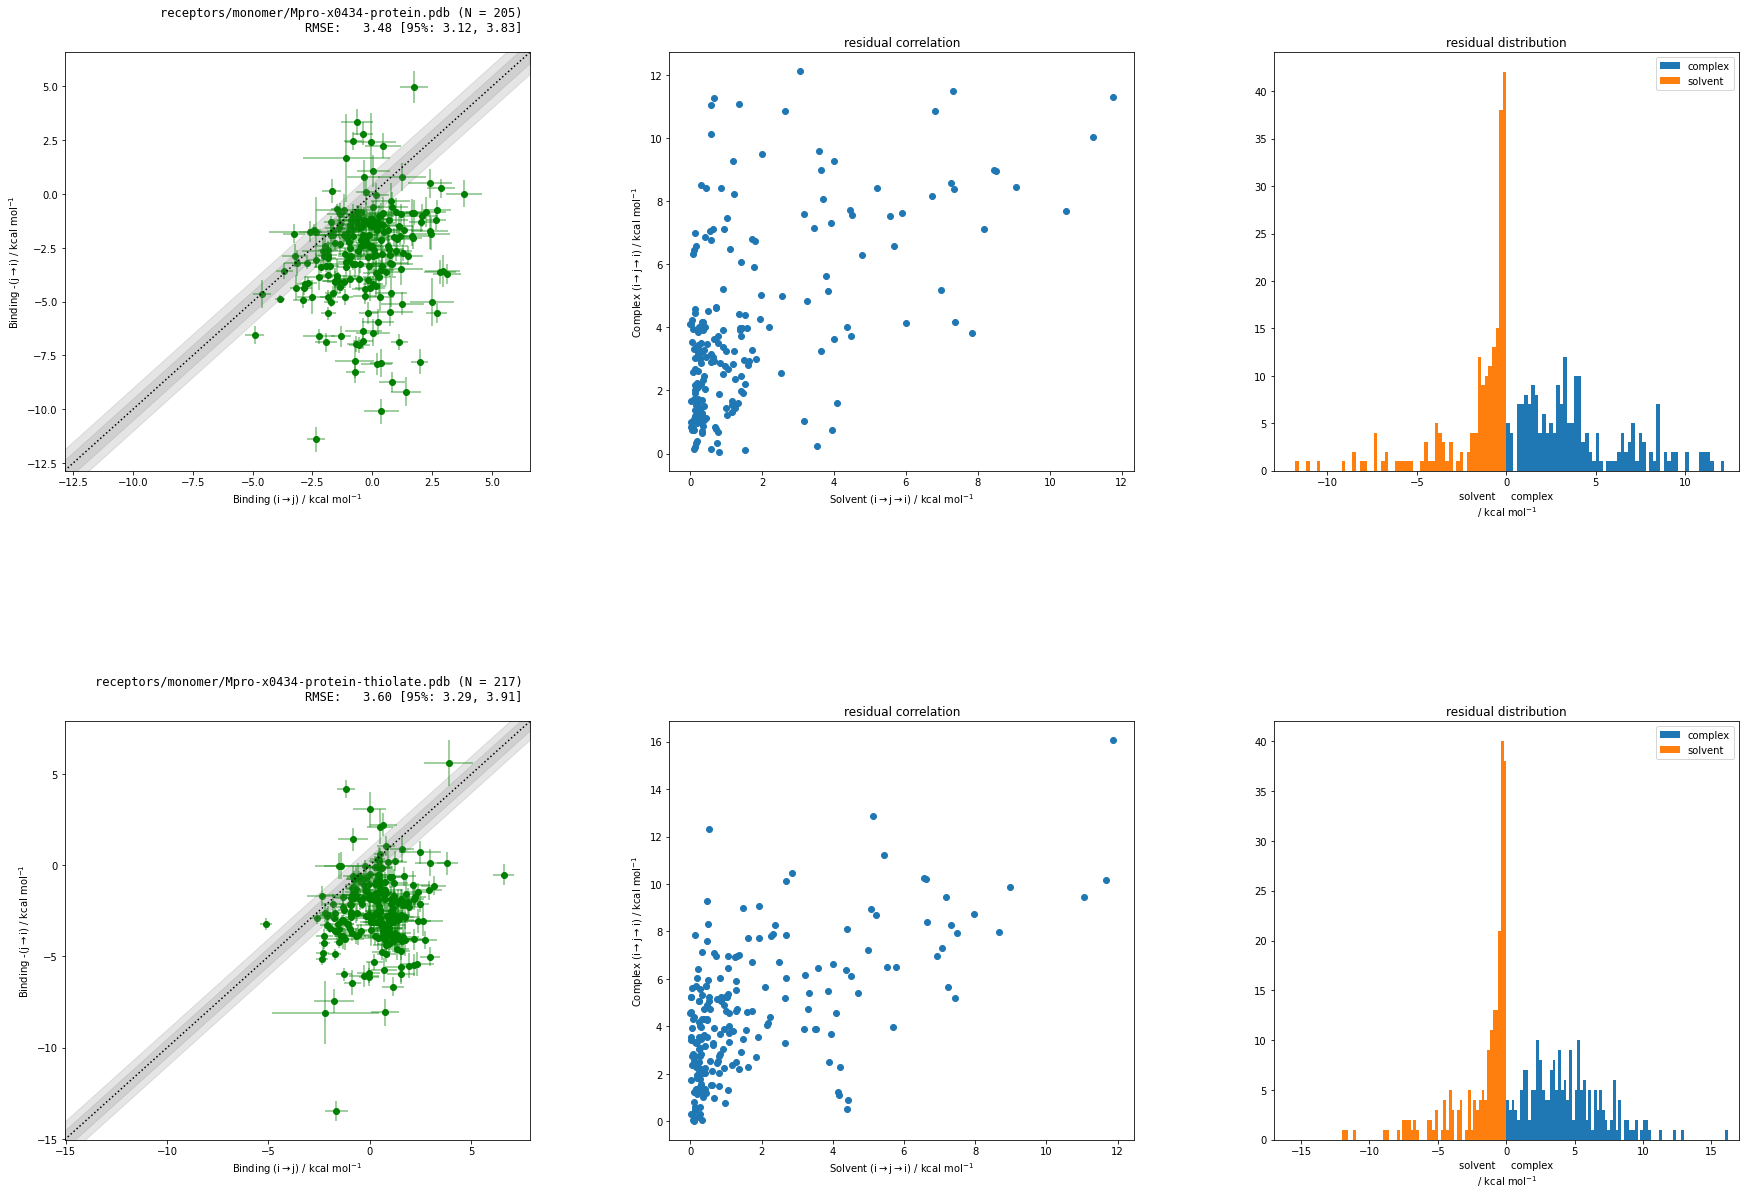

In [69]:
fig, axes = plt.subplots(ncols=3,nrows=len(graphs),figsize=(30,10*len(graphs)))
residuals = {}
consistency = {}
for p in graphs.keys():
    residuals[p] = {'complex':[],'solvent':[],'complex0':[],'solvent0':[],'complex1':[],'solvent1':[]}
    consistency[p] = {'x':[],'y':[],'xerr':[],'yerr':[]}

order = {}
for i, p in enumerate(graphs.keys()):
    order[p] = i

for i in range(420, 1302,2):
    f = details[str(i)]
    r = details[str(i+1)]

    protein = details[str(i)]['protein']
    plt_id = order[protein]
    
    if 'complex_fes' in f and 'complex_fes' in r and 'solvent_fes' in f and 'solvent_fes' in r:
        f_binding = ((f['complex_fes'][0] - f['solvent_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole)
        f_binding_err = ((f['solvent_fes'][1]**0.5 + f['complex_fes'][1]**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
        r_binding = ((r['complex_fes'][0] - r['solvent_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole)
        r_binding_err = ((r['solvent_fes'][1]**0.5 + r['complex_fes'][1]**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)

        consistency[protein]['x'].append(f_binding)
        consistency[protein]['y'].append(-r_binding)
        consistency[protein]['xerr'].append(f_binding_err)
        consistency[protein]['yerr'].append(r_binding_err)

        axes[plt_id][0].errorbar(f_binding,-r_binding,xerr=f_binding_err,yerr=r_binding_err,alpha=0.5,color='green')
        axes[plt_id][0].scatter(f_binding,-r_binding,color='green')

        residuals[protein]['complex'].append(np.abs(((f['complex_fes'][0] + r['complex_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole)))
        residuals[protein]['solvent'].append(-np.abs(((f['solvent_fes'][0] + r['solvent_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole)))
        if 'complex_fes_GEN1' in f and 'complex_fes_GEN1' in r and 'solvent_fes_GEN1' in f and 'solvent_fes_GEN1' in r:
            residuals[protein]['complex0'].append(np.abs(((f['complex_fes_GEN0'][0] + r['complex_fes_GEN1'][0])*kT).value_in_unit(unit.kilocalories_per_mole)))
            residuals[protein]['solvent0'].append(-np.abs(((f['solvent_fes_GEN0'][0] + r['solvent_fes_GEN0'][0])*kT).value_in_unit(unit.kilocalories_per_mole)))
            residuals[protein]['complex1'].append(np.abs(((f['complex_fes_GEN1'][0] + r['complex_fes_GEN1'][0])*kT).value_in_unit(unit.kilocalories_per_mole)))
            residuals[protein]['solvent1'].append(-np.abs(((f['solvent_fes_GEN1'][0] + r['solvent_fes_GEN1'][0])*kT).value_in_unit(unit.kilocalories_per_mole)))

        
for key,i in order.items():

    statistics_string = ''
    for statistic in ['RMSE']:
        s = stats.bootstrap_statistic(np.asarray(consistency[key]['x']),np.asarray(consistency[key]['y']), statistic=statistic)
        string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
        statistics_string += string

    long_title = f'{key} (N = {len(np.asarray(consistency[key]["x"]))}) \n'+f'{statistics_string}'
    axes[i][0].set_title(long_title, fontsize=12, loc='right', horizontalalignment='right', family='monospace')
    axes[i][0].set_xlabel(r'Binding (i$\rightarrow$j) / kcal mol$^{-1}$')
    axes[i][0].set_ylabel(r'Binding -(j$\rightarrow$i) / kcal mol$^{-1}$')
    axes[i][1].scatter(-np.asarray(residuals[key]['solvent']),np.asarray(residuals[key]['complex']))
#     axes[i][1].scatter(-np.asarray(residuals[key]['solvent0']),np.asarray(residuals[key]['complex0']),label='GEN0')
#     axes[i][1].scatter(-np.asarray(residuals[key]['solvent1']),np.asarray(residuals[key]['complex1']),label='GEN1')
#     axes[i][1].legend()
    axes[i][1].set_title(f'residual correlation') 
    axes[i][1].set_xlabel(r'Solvent (i$\rightarrow$j$\rightarrow$i) / kcal mol$^{-1}$') 
    axes[i][1].set_ylabel(r'Complex (i$\rightarrow$j$\rightarrow$i) / kcal mol$^{-1}$') 

    xlimit = axes[i][0].get_xlim()
    ylimit = axes[i][0].get_ylim()
    limit = (min([xlimit[0],ylimit[0]]),max([xlimit[1],ylimit[1]]))
    axes[i][0].plot(limit,limit, 'k:')
    small_dist = 0.5


    axes[i][0].fill_between(limit, [limit[0] - small_dist, limit[1] - small_dist],
                     [limit[0] + small_dist, limit[1] + small_dist],
                     color='grey', alpha=0.2)
    axes[i][0].fill_between(limit, [limit[0] - small_dist*2, limit[1] - small_dist*2],
                     [limit[0] + small_dist*2, limit[1] + small_dist*2],
                     color='grey', alpha=0.2)
    axes[i][0].set_xlim(limit)
    axes[i][0].set_ylim(limit)

    minimum = np.floor(min(residuals[key]['solvent']))
    maximum = np.ceil(max(residuals[key]['complex']))
    bins = np.linspace(minimum,maximum,int(5*(maximum-minimum)+1))
    axes[i][2].hist(residuals[key]['complex'],bins=bins,label='complex')
    axes[i][2].hist(residuals[key]['solvent'],bins=bins,label='solvent')    
    axes[i][2].legend()
    axes[i][2].set_xlabel('solvent     complex\n'+r' / kcal mol$^{-1}$') 
    axes[i][2].set_title('residual distribution') 
    xlim = max([-minimum,maximum])
    axes[i][2].set_xlim(-xlim, xlim)

plt.subplots_adjust(hspace = 0.6,wspace = 0.3)
plt.show()


In [116]:
index_to_title = {}
title_to_index = {}
from perses.utils.openeye import *
for i in range(0,225):
    try:
        mol = createOEMolFromSDF('aminopyridines_for_chodera_lab-docked.sdf',index=i)
        index_to_title[i] = mol.GetTitle()
        title_to_index[mol.GetTitle()] = i
    except IndexError:
        pass

INFO:utils.openeye:molecule ADA-UNI-f8e79267-5                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule TRY-UNI-714a760b-16                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule EDJ-MED-e58735b6-2                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule MAT-POS-590ac91e-23                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule EDJ-MED-c9f55a56-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule BAR-COM-0f94fc3d-46                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule CHR-SOS-f7373dd1-4                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule JAN-GHE-83b26c96-8                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule BAR-COM-0f94fc3d-

INFO:utils.openeye:molecule DAR-DIA-842b4336-3                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule BAR-COM-0f94fc3d-28                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule LON-WEI-b8d98729-24                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule TRY-UNI-2eddb1ff-2                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule BEN-DND-61647d40-8                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule LON-WEI-d1c9908a-10                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule CHR-SOS-363cfb78-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule EDJ-MED-49816e9b-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule LON-WEI-b8d98729-

INFO:utils.openeye:molecule EDJ-MED-e58735b6-3                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule TRY-UNI-714a760b-24                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule DAR-DIA-23aa0b97-8                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule LON-WEI-adc59df6-39                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule LON-WEI-d1c9908a-13                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule ANN-UNI-26382800-3                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule WAR-XCH-eb7b662f-5                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule NAU-LAT-64f4b287-7                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule BAR-COM-4e090d3a-

KeyboardInterrupt: 

In [82]:
import csv
r_inhib_20 = {}
r_inhib_50 = {}
r_ic50 = {}
f_inhib_20 = {}
f_inhib_50 = {}
f_ic50 = {}

with open('aminopyridines_for_chodera_lab-docked.csv','r') as f:
    x = csv.reader(f)
    for i, row in enumerate(x):
        if i == 0:
            continue
        name = row[1]
        in20 = row[3]
        in50 = row[4]
        ic = row[5]
        r_inhib_20[name] = float(in20) if in20 != '' else None
        r_inhib_50[name] = float(in50) if in50 != '' else None
        r_ic50[name] = float(ic) if ic != '' else None
        in20 = row[6]
        in50 = row[7]
        ic = row[8]
        f_inhib_20[name] = float(in20) if in20 != '' else None
        f_inhib_50[name] = float(in50) if in50 != '' else None
        f_ic50[name] = float(ic) if ic != '' else None

In [72]:
def generate_absolute_values(g):
    f_i_calc, C_calc = mle(g, factor='calc_DDG')
    index_node_map = {i:j for i, j in enumerate(g.nodes)}

    variance = np.diagonal(C_calc)
    for i, (f_i, df_i) in enumerate(zip(f_i_calc, variance**0.5)):
        m = index_node_map[i]
        g.nodes[m]['calc_DG'] = f_i
        g.nodes[m]['calc_dDG'] = df_i

    f_i_calc, C_calc = mle(g, factor='exp_DDG')
    variance = np.diagonal(C_calc)
    for i, (f_i, df_i) in enumerate(zip(f_i_calc, variance**0.5)):
        m = index_node_map[i]
        g.nodes[m]['exp_DG'] = f_i
        g.nodes[m]['exp_dDG'] = df_i
        
        
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

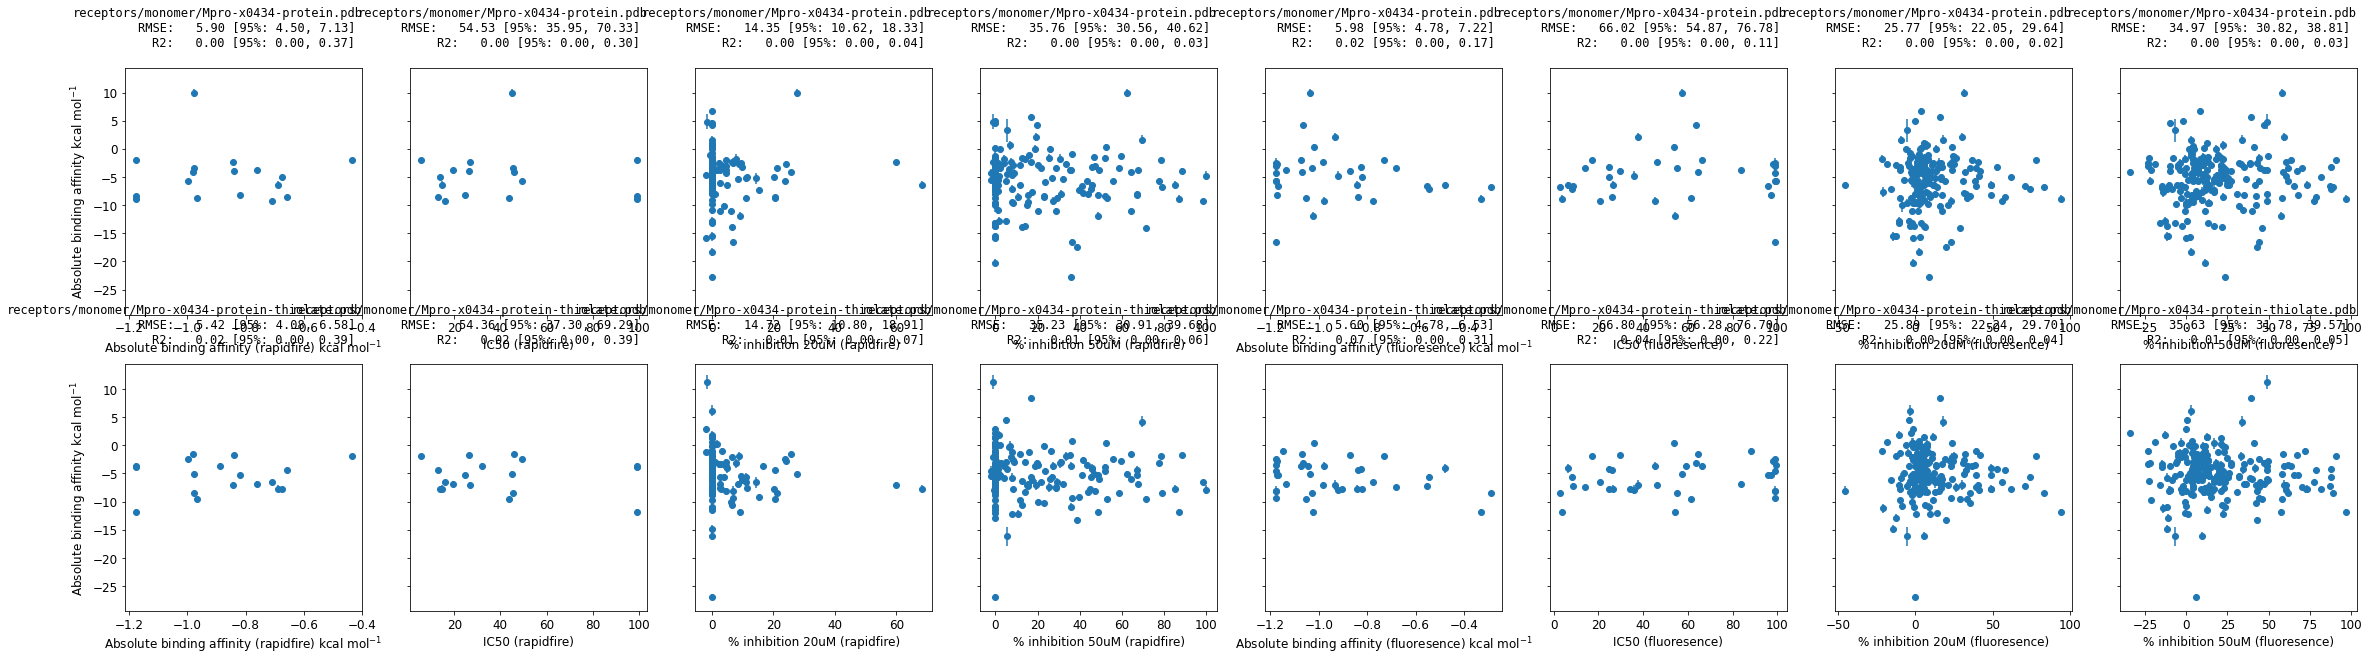

In [107]:
fig, axes = plt.subplots(ncols=8,nrows=2,figsize=(40, 10),sharey=True)

for i, protein in enumerate(graphs.keys()):
    g = graphs[protein]
    generate_absolute_values(g)
    for j, item in enumerate([r_ic50, r_ic50, r_inhib_20, r_inhib_50, f_ic50, f_ic50, f_inhib_20, f_inhib_50]):
        xs = []
        y_err = []
        ys = []
        for node in g.nodes(data=True):
            index = node[0]
            ic = item[index_to_title[index]]
            if ic is not None:
                ys.append(node[1]['calc_DG'])
                y_err.append(node[1]['calc_dDG'])
                if j in [0,4]:
                    xs.append(-0.59*np.log10(ic))
                else:
                    xs.append(ic)
        axes[i][j].scatter(xs,ys)
        axes[i][j].errorbar(xs,ys,yerr=y_err,ls='none')

        
        statistics_string = f'{protein}\n'
        for statistic in ['RMSE','R2']:
            s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
            string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
            statistics_string += string
        axes[i][j].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i][0].set_ylabel(f'Absolute binding affinity '+r'kcal mol$^{-1}$')
    axes[i][0].set_xlabel(f'Absolute binding affinity (rapidfire) '+r'kcal mol$^{-1}$')
    axes[i][1].set_xlabel(f'IC50 (rapidfire)')
    axes[i][2].set_xlabel('% inhibition 20uM (rapidfire)')
    axes[i][3].set_xlabel('% inhibition 50uM (rapidfire)')
    axes[i][4].set_xlabel(f'Absolute binding affinity (fluoresence) '+r'kcal mol$^{-1}$')
    axes[i][5].set_xlabel(f'IC50 (fluoresence)')
    axes[i][6].set_xlabel('% inhibition 20uM (fluoresence)')
    axes[i][7].set_xlabel('% inhibition 50uM (fluoresence)')    
        
plt.show()




# ### AND NOW IGNORING VALUES OF ZERO

# fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(30, 20),sharey=True)

# for i, protein in enumerate(graphs.keys()):
#     g = graphs[protein]
#     generate_absolute_values(g)
#     for j, item in enumerate([ic50, inhib_20, inhib_50]):
#         xs = []
#         y_err = []
#         ys = []
#         for node in g.nodes(data=True):
#             index = node[0]
#             ic = item[index_to_title[index]]
#             if ic is not None and int(ic) != 0:
#                 ys.append(node[1]['calc_DG'])
#                 y_err.append(node[1]['calc_dDG'])
#                 xs.append(ic)
#         axes[i][j].scatter(xs,ys)
#         axes[i][j].errorbar(xs,ys,yerr=y_err,ls='none')

        
#         statistics_string = f'{protein}\n'
#         for statistic in ['RMSE','R2']:
#             s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
#             string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
#             statistics_string += string
#         axes[i][j].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

#     axes[i][0].set_ylabel(f'Absolute binding affinity '+r'kcal mol$^{-1}$')
#     axes[i][0].set_xlabel(f'IC50')
#     axes[i][1].set_xlabel('r_inhibition_at_20_uM')
#     axes[i][2].set_xlabel('r_inhibition_at_50_uM')
    
        
# plt.show()

#### Plots of fluorescence vs. rapidfire agreement

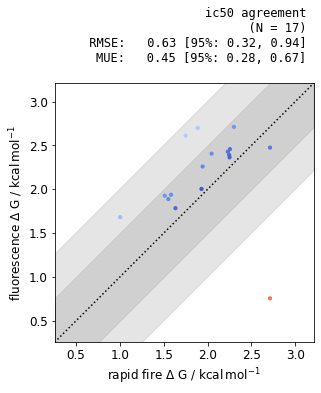

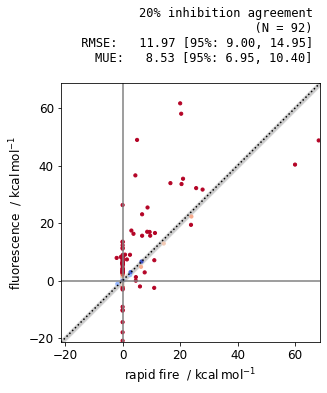

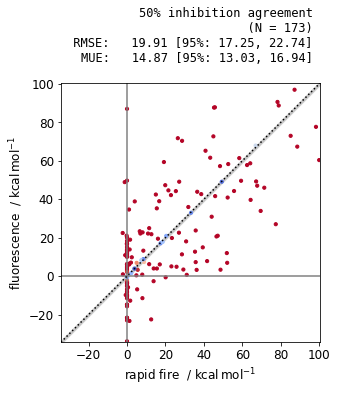

In [108]:
x = []
y = []


for i in r_ic50.keys():
    if r_ic50[i] is not None and f_ic50[i] is not None:
        x.append(0.59*np.log(r_ic50[i]))
        y.append(0.59*np.log(f_ic50[i]))

plotting._master_plot(np.asarray(x), np.asarray(y),title='ic50 agreement',xlabel='rapid fire',ylabel='fluorescence',quantity='$\\Delta$ G')

plt.show()

x = []
y = []


for i in r_inhib_20.keys():
    if r_inhib_20[i] is not None and f_inhib_20[i] is not None:
        x.append(r_inhib_20[i])
        y.append(f_inhib_20[i])

plotting._master_plot(np.asarray(x), np.asarray(y),title='20% inhibition agreement',xlabel='rapid fire',ylabel='fluorescence',quantity='')

plt.show()


x = []
y = []


for i in r_inhib_50.keys():
    if r_inhib_50[i] is not None and f_inhib_50[i] is not None:
        x.append(r_inhib_50[i])
        y.append(f_inhib_50[i])

plotting._master_plot(np.asarray(x), np.asarray(y),title='50% inhibition agreement',xlabel='rapid fire',ylabel='fluorescence',quantity='')

plt.show()

### The following plots avoid the use of MLE, which will be unreliable given the forwards vs. backwards hysteresis

##### It's likely that there is an error in the following plots, either with a sign somehwere, or from converting from IC50s to DDGs

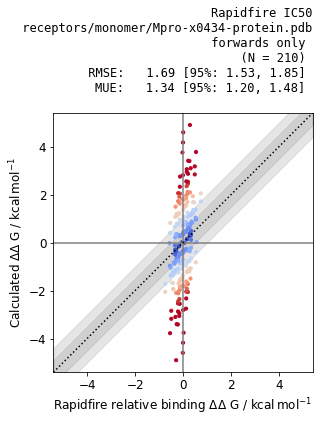

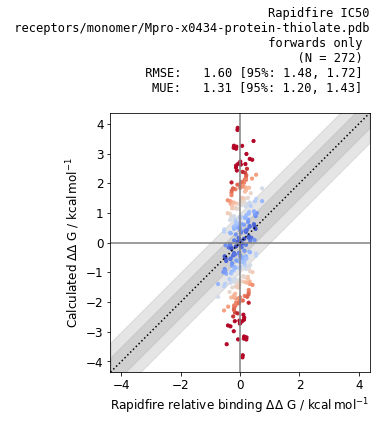

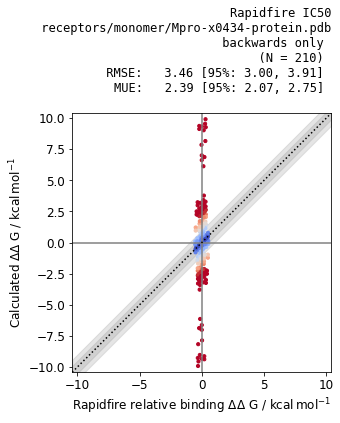

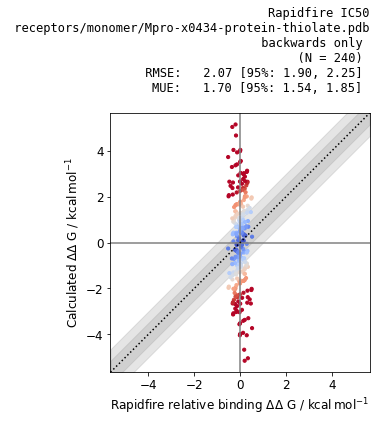

In [150]:
### forward only

for protein, g in graphs.items():
    xs = []
    ys = []
    for ligA in r_ic50.keys():
        for ligB in r_ic50.keys():
            if ligA != ligB and r_ic50[ligA] is not None and r_ic50[ligB] is not None:
                exp_ddg = -0.59*np.log10(r_ic50[ligA]/r_ic50[ligB])
                try:
                    a = g.get_edge_data(0,title_to_index[ligA])
                    b = g.get_edge_data(0,title_to_index[ligB])
                    diff = b['calc_DDG'] - a['calc_DDG']
                    xs.append(exp_ddg)
                    ys.append(diff)
                except:
                    continue
    plotting._master_plot(np.asarray(xs),np.asarray(ys),xlabel='Rapidfire relative binding',title=f'Rapidfire IC50\n {protein}\n forwards only')
    plt.show()
    
### backward only
for protein, g in graphs.items():
    xs = []
    ys = []
    for ligA in r_ic50.keys():
        for ligB in r_ic50.keys():
            if ligA != ligB and r_ic50[ligA] is not None and r_ic50[ligB] is not None:
                exp_ddg = -0.59*np.log10(r_ic50[ligA]/r_ic50[ligB])
                try:
                    a = g.get_edge_data(title_to_index[ligA],0)
                    b = g.get_edge_data(title_to_index[ligB],0)
                    diff = a['calc_DDG'] - b['calc_DDG']
                    xs.append(exp_ddg)
                    ys.append(diff)
                except:
                    continue
    plotting._master_plot(np.asarray(xs),np.asarray(ys),xlabel='Rapidfire relative binding',title=f'Rapidfire IC50\n {protein}\n backwards only')
    plt.show()

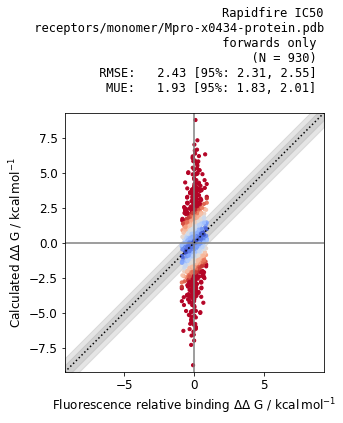

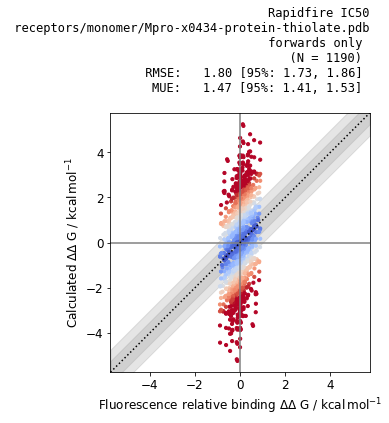

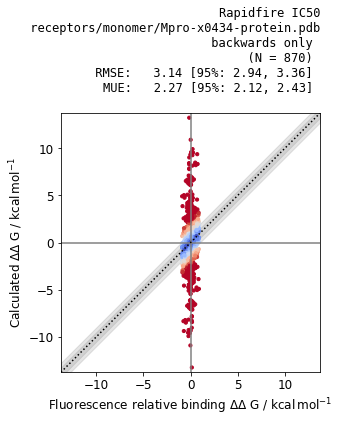

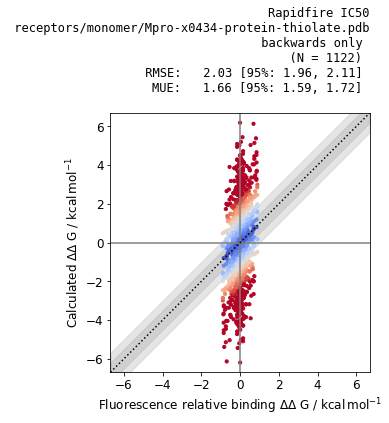

In [151]:
### forward only

for protein, g in graphs.items():
    xs = []
    ys = []
    for ligA in f_ic50.keys():
        for ligB in f_ic50.keys():
            if ligA != ligB and f_ic50[ligA] is not None and f_ic50[ligB] is not None:
                exp_ddg = -0.59*np.log10(f_ic50[ligA]/f_ic50[ligB])
                try:
                    a = g.get_edge_data(0,title_to_index[ligA])
                    b = g.get_edge_data(0,title_to_index[ligB])
                    diff = b['calc_DDG'] - a['calc_DDG']
                    xs.append(exp_ddg)
                    ys.append(diff)
                except:
                    continue
    plotting._master_plot(np.asarray(xs),np.asarray(ys),xlabel='Fluorescence relative binding',title=f'Rapidfire IC50\n {protein}\n forwards only')
    plt.show()
    
### backward only
for protein, g in graphs.items():
    xs = []
    ys = []
    for ligA in f_ic50.keys():
        for ligB in f_ic50.keys():
            if ligA != ligB and f_ic50[ligA] is not None and f_ic50[ligB] is not None:
                exp_ddg = -0.59*np.log10(f_ic50[ligA]/f_ic50[ligB])
                try:
                    a = g.get_edge_data(title_to_index[ligA],0)
                    b = g.get_edge_data(title_to_index[ligB],0)
                    diff = a['calc_DDG'] - b['calc_DDG']
                    xs.append(exp_ddg)
                    ys.append(diff)
                except:
                    continue
    plotting._master_plot(np.asarray(xs),np.asarray(ys),xlabel='Fluorescence relative binding',title=f'Rapidfire IC50\n {protein}\n backwards only')
    plt.show()